# Automatic detection of motion artefacts in the ECG signal from a wearable sensor using methods of artificial intelligence
## Master's thesis

In [291]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from scipy.stats import mode

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, BatchNormalization, concatenate
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.callbacks import LearningRateScheduler

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

## Helper functions

In [2]:
'''
    Function used to plot training and validation progress
'''
def plot_metrics(history, metric):
    train = history.history[metric]
    val = history.history['val_' + str(metric)]

    plt.figure(figsize=(10, 5))
    
    plt.plot(train, label='Training ' + str(metric), color='blue')
    plt.plot(val, label='Validation ' + str(metric), color='red')
    
    plt.title('Training and validation ' + str(metric))
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    
    plt.legend()
    plt.show()

In [3]:
'''
    Function used to plot confusion matrix for multi class classification
'''
def plot_confusion_matrix(y_test, y_pred, class_labels):
    conf_mat = confusion_matrix(np.array(y_test), np.array(y_pred))

    # Normalize confusion matrix to show percentages
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(conf_mat_norm, 
                annot=True, 
                fmt='.2%', 
                cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=ax
               )
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Normalized)')
    
    plt.show()
    
    return fig

In [288]:
'''
    Performs train-test-validation split, making sure the data is stratified
'''
def train_test_validation_split(df_norm, df_fft, target, validation=True):
    X = df_norm.drop(['activity', 'artefact'], axis=1).copy()
    X_fft = df_fft.drop(['activity', 'artefact', 'electrode'], axis=1).copy()

    y = df_norm[target].copy()

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40, stratify = y)
    
    # Train validation split - 0.125 x 0.8 = 0.1
    if validation:
        X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                          y_train, 
                                                          test_size = 0.125,      
                                                          random_state = 40, 
                                                          stratify = y_train)
    else:
        X_val = pd.DataFrame()
        y_val = pd.DataFrame()

    # Take the same split from fft dataframe
    X_train_fft = X_fft.iloc[X_train.index]
    X_test_fft = X_fft.iloc[X_test.index]
    X_val_fft = X_fft.iloc[X_val.index]
    
    return X_train, X_test, X_val, X_train_fft, X_test_fft, X_val_fft, y_train, y_test, y_val

In [290]:
'''
    Separates electrode input from EKG input
'''
def get_electrode_input(X_train, X_test, X_val):
    X_train_el = X_train['electrode']
    X_train = X_train.drop(['electrode'], axis=1)
    
    X_test_el = X_test['electrode']
    X_test = X_test.drop(['electrode'], axis=1)
    
    if not X_val.empty:
        X_val_el = X_val['electrode']
        X_val = X_val.drop(['electrode'], axis=1)
    else:
        X_val_el = pd.DataFrame()
    
    return X_train, X_test, X_val, X_train_el, X_test_el, X_val_el

In [289]:
'''
    Checks if the data was split correctly, if the dataset indices match
'''
def check_index(X_train, X_test, X_val, X_train_fft, X_test_fft, X_val_fft, y_train, y_test, y_val):
    print('Train dataset indices match:      ', X_train.index.equals(X_train_fft.index) and 
                                                X_train.index.equals(y_train.index))

    print('Test dataset indices match:       ', X_test.index.equals(X_test_fft.index) and
                                                X_test.index.equals(y_test.index))

    print('Validation dataset indices match: ', X_val.index.equals(X_val_fft.index) and
                                                X_val.index.equals(y_val.index))

## Dataset creation
- Traverse the data directory to create data file - label file pairs
- Go through all of the pairs and construct the output dataframe - extract corresponding segment from signal and include labels
- Check if the dataset is well balanced both in terms of artefact and activity type

In [4]:
PARENT_DIR = '../../data'

ACTIVITIES_NUM = 5               # Number of activity type classes
ARTEFACT_NUM = 4                 # Number of artefact type classes

SEG_LEN_SEC = 2
FS = 500

SEG_LEN = FS * SEG_LEN_SEC 

FFT_LEN = 200

In [5]:
'''
    Create data-label file pairs from the parent path
'''
def create_data_label_pairs():
    data_label_pairs = {}

    # Traverse all ID directories to get the data-label file pairs
    for id_dir in os.listdir(PARENT_DIR):
        data_dir = os.path.join(PARENT_DIR, id_dir)

        # Check if the path is a directory
        if os.path.isdir(data_dir):
            labels_dir = os.path.join(data_dir, 'labels')

            # Double check that data and labels subdirectories exist
            if os.path.exists(data_dir) and os.path.exists(labels_dir):

                # Iterate over .csv files in data directory
                for data_file in os.listdir(data_dir):
                    if data_file.endswith('.csv'):

                        # Check if corresponding label file exists
                        label_file_name = data_file.split('.')[0] + '_' + str(SEG_LEN_SEC) + '.csv'

                        label_path = os.path.join(labels_dir, label_file_name)
                        data_path = os.path.join(data_dir, data_file)

                        if os.path.exists(data_path) and os.path.exists(label_path):
                            data_label_pairs[data_path] = label_path
                            
    return data_label_pairs

data_label_pairs = create_data_label_pairs()

In [6]:
'''
    Create dataframe from data-label file pairs
'''
def create_dataframe(data_label_pairs):
    df = pd.DataFrame(columns = ['artefact', 'activity', 'electrode'])
    data = []

    # Iterate over matched data-label pairs
    for data_file, label_file in data_label_pairs.items():
        
        df_data = pd.read_csv(data_file, delimiter=';', names=['timestamp', 'value'])
        df_labels = pd.read_csv(label_file, delimiter=';')
        
        electrode = int(label_file.split('_')[1])

        # Iterate over rows in label file
        for idx, row in df_labels.iterrows():
            
            # Extract segment from data based on start and end indices
            start_idx, end_idx = row['start'], row['end']
            segment = df_data.iloc[start_idx:end_idx]['value'].values

            segment = pd.DataFrame(segment, columns=['segment']).T

            # Add activity_type and artefact_type columns
            segment['activity'] = row['activity']
            segment['artefact'] = row['artifact']
            segment['electrode'] = electrode

            data.append(segment)

    return pd.concat(data, ignore_index=True)

df = create_dataframe(data_label_pairs)
df

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,activity,artefact,electrode
0,2134,2125,2130,2131,2137,2136,2143,2141,2149,2155,...,2060,2055,2053,2054,2046,2042,2043,0,1,1
1,2042,2041,2042,2039,2036,2034,2033,2029,2026,2028,...,2117,2127,2133,2147,2145,2149,2150,0,1,1
2,2148,2149,2150,2154,2154,2157,2161,2165,2164,2153,...,2097,2103,2107,2114,2121,2119,2117,0,1,1
3,2120,2125,2121,2125,2125,2124,2124,2119,2108,2104,...,2272,2273,2275,2275,2277,2278,2281,0,1,1
4,2280,2278,2280,2282,2278,2280,2272,2271,2272,2272,...,2151,2167,2180,2200,2207,2214,2218,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,2612,2614,2591,2535,2445,2311,2143,1956,1744,1522,...,2115,2128,2138,2142,2136,2107,2059,3,2,2
4598,2022,1983,1965,1945,1935,1932,1938,1944,1948,1960,...,2181,2209,2218,2214,2205,2194,2180,3,2,2
4599,2167,2152,2164,2172,2178,2190,2211,2232,2245,2268,...,2031,2015,1973,1915,1828,1710,1577,3,2,2
4600,1427,1256,1067,875,691,526,393,260,186,189,...,2643,2591,2555,2534,2518,2503,2490,3,2,2


In [7]:
df['activity'].value_counts()

2    928
1    927
4    918
3    915
0    914
Name: activity, dtype: int64

In [8]:
df['artefact'].value_counts()

1    2099
2    1696
3     461
4     346
Name: artefact, dtype: int64

## Data preprocessing
- Normalize the data to the range of a 12-bit ADC using min-max normalization
- Create new dataframe containing magnitude spectrum of each ECG segment

In [9]:
drop_columns = ['activity', 'artefact', 'electrode']
min_val, max_val = 0, 4096

# Min-max normalized data
normalized = (df.loc[:, ~df.columns.isin(drop_columns)] - min_val) / (max_val - min_val)

# Apply min-max normalization to each column
df_norm = df.copy()

df_norm.loc[:, ~df_norm.columns.isin(drop_columns)] = normalized
df_norm

,0,1,2,3,4,5,6,7,8,9,...,993,994,995,996,997,998,999,activity,artefact,electrode
0,0.520996,0.518799,0.520020,0.520264,0.521729,0.521484,0.523193,0.522705,0.524658,0.526123,...,0.502930,0.501709,0.501221,0.501465,0.499512,0.498535,0.498779,0,1,1
1,0.498535,0.498291,0.498535,0.497803,0.497070,0.496582,0.496338,0.495361,0.494629,0.495117,...,0.516846,0.519287,0.520752,0.524170,0.523682,0.524658,0.524902,0,1,1
2,0.524414,0.524658,0.524902,0.525879,0.525879,0.526611,0.527588,0.528564,0.528320,0.525635,...,0.511963,0.513428,0.514404,0.516113,0.517822,0.517334,0.516846,0,1,1
3,0.517578,0.518799,0.517822,0.518799,0.518799,0.518555,0.518555,0.517334,0.514648,0.513672,...,0.554688,0.554932,0.555420,0.555420,0.555908,0.556152,0.556885,0,1,1
4,0.556641,0.556152,0.556641,0.557129,0.556152,0.556641,0.554688,0.554443,0.554688,0.554688,...,0.525146,0.529053,0.532227,0.537109,0.538818,0.540527,0.541504,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,0.637695,0.638184,0.632568,0.618896,0.596924,0.564209,0.523193,0.477539,0.425781,0.371582,...,0.516357,0.519531,0.521973,0.522949,0.521484,0.514404,0.502686,3,2,2
4598,0.493652,0.484131,0.479736,0.474854,0.472412,0.471680,0.473145,0.474609,0.475586,0.478516,...,0.532471,0.539307,0.541504,0.540527,0.538330,0.535645,0.532227,3,2,2
4599,0.529053,0.525391,0.528320,0.530273,0.531738,0.534668,0.539795,0.544922,0.548096,0.553711,...,0.495850,0.491943,0.481689,0.467529,0.446289,0.417480,0.385010,3,2,2
4600,0.348389,0.306641,0.260498,0.213623,0.168701,0.128418,0.095947,0.063477,0.045410,0.046143,...,0.645264,0.632568,0.623779,0.618652,0.614746,0.611084,0.607910,3,2,2


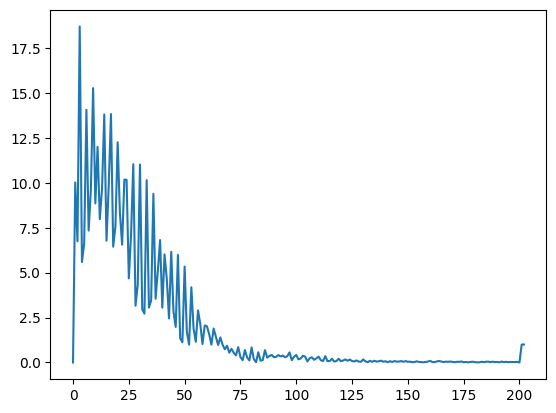

In [10]:
'''
    Create dataframe containing first N points of a spectrum of each ECG segment
'''
def create_fft_dataframe(df, N_freq):    
    ecg_signals = df.iloc[:, :SEG_LEN].values
    
    segment_means = np.mean(ecg_signals, axis=1, keepdims=True)

    # Remove the DC component by subtracting the mean from each segment
    ecg_signals = ecg_signals - segment_means

    # Compute FFT for each ECG signal
    fft_results = np.abs(np.fft.fft(ecg_signals, axis=1))

    # Extract only the first N frequencies
    fft_magnitudes = fft_results[:, :N_freq]

    activity_types = df['activity'].values.reshape(-1, 1)
    artefact_types = df['artefact'].values.reshape(-1, 1)
    electrode_types = df['electrode'].values.reshape(-1, 1)

    df_fft = np.hstack((fft_magnitudes, artefact_types))

    df_fft = np.hstack((fft_magnitudes, activity_types, artefact_types, electrode_types))
    df_fft = pd.DataFrame(df_fft, columns=[f'fft_{i}' for i in range(N_freq)] + drop_columns)
    
    return df_fft
    
df_fft = create_fft_dataframe(df_norm, FFT_LEN)

# Plot an example FFT spectrum
plt.plot(df_fft.iloc[0, :1000].values)
plt.show()

## Activity classification task

### Train test split
- Split the dataset into training and testing set
- One-hot encode data labels, to match the output shape of the model

In [243]:
(X_train_act, 
X_test_act, 
X_val_act, 
X_train_act_fft, 
X_test_act_fft, 
X_val_act_fft, 
y_train_act, 
y_test_act, 
y_val_act) = train_test_validation_split(df_norm, df_fft, 'activity', False)

# Get electrode input in the required shape
X_train_act, X_test_act, X_val_act, X_train_act_el, X_test_act_el, X_val_act_el = get_electrode_input(X_train_act, 
                                                                                                      X_test_act, 
                                                                                                      X_val_act)

# One-hot encoding of the output variable
y_train_act_enc = tf.keras.utils.to_categorical(y_train_act, num_classes = ACTIVITIES_NUM)
y_val_act_enc = tf.keras.utils.to_categorical(y_val_act, num_classes = ACTIVITIES_NUM)

In [244]:
# Check if the indices are equal
check_index(X_train_act, X_test_act, X_val_act, 
            X_train_act_fft, X_test_act_fft, X_val_act_fft, 
            y_train_act, y_test_act, y_val_act)

Train dataset indices match:       True
Test dataset indices match:        True
Validation dataset indices match:  True


In [245]:
# Check if the train data is stratified
y_train_act.value_counts()

2    742
1    742
4    734
3    732
0    731
Name: activity, dtype: int64

### Model architectures

Possible parameter options:
- __Epochs:__ Tried up to 100, the convergence is very slow to none after about 20-30 epochs
- __Batch size and learning rate:__ The combination of lr = 0.001 and batch_size = 16 seems to be the best one, tried batch sizes from 8 to 512, learning rates from 0.00001 to 0.01
- __Loss:__ Categorical cross-entropy, Kullback-Leibler divergence behaviour in this case possibly the same as cross-entropy
- __Output activation:__ Softmax, nothing else makes much sense
- __Input activation:__ ReLU, should help with vanishing gradient

Efforts to stabilize training and reduce overfitting:
- __Dropout:__ Tried different rates, placed dropout layers after each dense layer, worsened performance
- __Batch normalization:__ Placed batch normalization layers after each dense layer, worsened performance
- __L2 Regularization:__ Tried using L2 regularization for all dense layers, worsened performance
- __Weight decay:__ Tried using L2 regularization as weight decay in optimizer
- __Learning rate scheduling:__ Slightly improved performance

In [216]:
params = {
    'epochs': 20,
    'batch_size': 16,
    'learning_rate': 0.001, 
    'dropout': 0.3,
    'optimizer': 'Adam',
    'hidden_activation': 'relu',
    'output_activation': 'softmax',
    'loss': 'categorical_crossentropy',
    'metric': 'accuracy',
    'weight_decay': 0
}

In [217]:
'''
    Custom learning rate schedule function, reduces learning rate based on epoch number
'''
def lr_schedule(epoch):
    initial_lr = params['learning_rate']
    
    # Use initial learning rate for the first 10 epochs
    if epoch < 10:
        return initial_lr  
    # Modify the learning rate by a factor after 10 epochs
    else:
        return initial_lr * 0.2
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [299]:
'''
    Activity type classification model, ECG input together with FFT
'''
def activity_classifier(ecg_len, fft_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name = 'signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name = 'frequency_input')
    
    concatenated = concatenate([ecg_input, fft_input])
    
    # Fully connected and dropout layers
    dense1 = Dense(1024, activation = params['hidden_activation'])(concatenated)

    dense2 = Dense(512, activation = params['hidden_activation'])(dense1)
    
    dense3 = Dense(256, activation = params['hidden_activation'])(dense2)
    
    dense4 = Dense(128, activation = params['hidden_activation'])(dense3)

    dense5 = Dense(64, activation = params['hidden_activation'])(dense4)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation = params['output_activation'], name = 'output')(dense5)
    
    opt = Adam(weight_decay = params['weight_decay'])
    
    model = Model(inputs = [ecg_input, fft_input], outputs = output)
    
    model.compile(optimizer = opt, loss = params['loss'], metrics = params['metric'])
    
    return model


model = activity_classifier(SEG_LEN, FFT_LEN, ACTIVITIES_NUM)
model.summary()

Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal_input (InputLayer)   [(None, 1000)]               0         []                            
                                                                                                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 concatenate_61 (Concatenat  (None, 1200)                 0         ['signal_input[0][0]',        
 e)                                                                  'frequency_input[0][0]']     
                                                                                           

In [318]:
'''
    Activity type classification convolutional model, ECG input together with FFT
'''
def activity_classifier_conv(ecg_len, fft_len, electrode_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name='signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name='frequency_input')
    
#     electrode_input = Input(shape=(electrode_len,), name='electrode_input')
    
    # Fully connected and dropout layers for ECG signal
    ecg_dense1 = Dense(1024, activation=params['hidden_activation'])(ecg_input)
    ecg_dense2 = Dense(512, activation=params['hidden_activation'])(ecg_dense1)
    
    fft_reshaped = Reshape((fft_len, 1))(fft_input)
    
    # Convolutional layers for FFT   
    conv1 = Conv1D(64, kernel_size=5, activation='relu')(fft_reshaped)  # Increase number of filters
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, kernel_size=5, activation='relu')(pool1)  # Increase number of filters and kernel size
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten_fft = Flatten()(pool2)
    
    # Concatenate outputs from dense and convolutional layers
    concatenated = concatenate([ecg_dense2, flatten_fft])
    
    # Fully connected layers
    dense3 = Dense(256, activation=params['hidden_activation'])(concatenated)
    dense4 = Dense(128, activation=params['hidden_activation'])(dense3)
    
    dense5 = Dense(64, activation=params['hidden_activation'])(dense4)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation=params['output_activation'], name='output')(dense5)
    
    # Optimizer with weight decay
    opt = Adam(weight_decay=params['weight_decay'])
    
    model = Model(inputs=[ecg_input, fft_input], outputs=output)
    
    model.compile(optimizer=opt, loss=params['loss'], metrics=[params['metric']])
    
    return model

model = activity_classifier_conv(SEG_LEN, FFT_LEN, 1, ACTIVITIES_NUM)
model.summary()

Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 reshape_60 (Reshape)        (None, 200, 1)               0         ['frequency_input[0][0]']     
                                                                                                  
 conv1d_123 (Conv1D)         (None, 196, 64)              384       ['reshape_60[0][0]']          
                                                                                                  
 max_pooling1d_123 (MaxPool  (None, 98, 64)               0         ['conv1d_123[0][0]']   

### Training

In [320]:
# Init Neptune.ai project
run = neptune.init_run(
    project = 'veronika.kalouskova/DP-Activity-Classification',
    api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTY5NGI5ZS0xNzk1LTQwYjItYjc0Ny1lZWNmZjdjZjg1MzEifQ==',
)

# Log model parameters into Neptune
run['parameters'] = params

# Log model summary and architecture into Neptune
neptune_callback = NeptuneCallback(run=run)

history = model.fit([X_train_act, X_train_act_fft],
                    y_train_act_enc, 
                    epochs = params['epochs'], 
                    batch_size = params['batch_size'], 
                    validation_data=([X_val_act, X_val_act_fft], y_val_act_enc),
                    callbacks=[neptune_callback, lr_scheduler]
                   )

# Log model architecture and weights into Neptune
model.save('models/model.keras')

run['saved_model'].upload('models/model.keras')


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-199
Epoch 1/20
231/231 [==============================] - 6s 28ms/step - loss: 0.3227 - accuracy: 0.8921 - lr: 0.0010
Epoch 2/20
231/231 [==============================] - 7s 30ms/step - loss: 0.2153 - accuracy: 0.9218 - lr: 0.0010
Epoch 3/20
231/231 [==============================] - 7s 30ms/step - loss: 0.2050 - accuracy: 0.9315 - lr: 0.0010
Epoch 4/20
231/231 [==============================] - 6s 25ms/step - loss: 0.0823 - accuracy: 0.9698 - lr: 0.0010
Epoch 5/20
231/231 [==============================] - 6s 24ms/step - loss: 0.0805 - accuracy: 0.9723 - lr: 0.0010
Epoch 6/20
231/231 [==============================] - 6s 24ms/step - loss: 0.0469 - accuracy: 0.9870 - lr: 0.0010
Epoch 7/20
231/231 [==============================] - 6s 26ms/step - loss: 0.0875 - accuracy: 0.9756 - lr: 0.0010
Epoch 8/20
231/231 [==============================] - 7s 29ms/st

### Evaluation

29/29 [==============================] - 0s 6ms/step


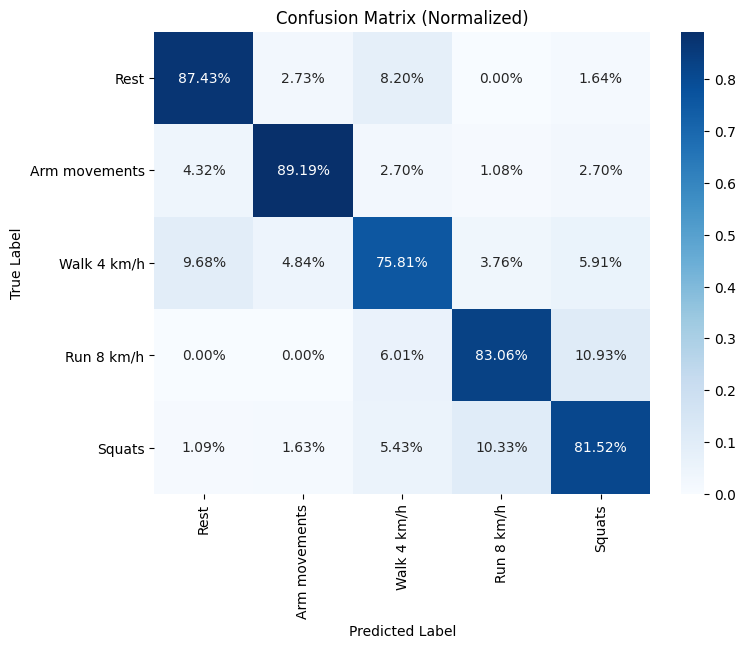

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-199/metadata
[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on

In [321]:
preds_act = model.predict([X_test_act, X_test_act_fft])
y_pred_act = np.argmax(preds_act, axis=1)

accuracy = accuracy_score(y_test_act, y_pred_act)
run["eval/accuracy"] = accuracy

class_labels = ['Rest', 'Arm movements', 'Walk 4 km/h', 'Run 8 km/h', 'Squats']

fig = plot_confusion_matrix(y_test_act, y_pred_act, class_labels)
run["eval/confusion_matrix"] = fig

run.stop()

### Ensemble bagging

In [297]:
def bagging_ensemble(num_models, X_train, X_train_fft, y_train, X_val, X_val_fft, y_val, X_test, X_test_fft):
    models = []

    # Split the training data into subsets for bagging
    for i in range(num_models):
        # Bootstrap samples
        X_bag_train, _, X_bag_train_fft, _, y_bag_train, _ = train_test_split(X_train, 
                                                                              X_train_fft, 
                                                                              y_train,
                                                                              test_size = 0.4, 
                                                                              random_state = i, 
                                                                              stratify = y_train)

        model = activity_classifier_conv(SEG_LEN, FFT_LEN, 1, ACTIVITIES_NUM)

        # Train the model on the bagged subset
        history = model.fit([X_bag_train, X_bag_train_fft],
                             y_bag_train,
                             epochs = params['epochs'],
                             batch_size = params['batch_size'],
                             validation_data=([X_val, X_val_fft], y_val),
                             callbacks=[lr_scheduler])

        models.append(model)
        
    predictions = []

    for model in models:
        preds_act = model.predict([X_test, X_test_fft])
        predictions.append(np.argmax(preds_act, axis=1))

    ensemble_pred = mode(predictions, axis=0)[0]
    ensemble_pred = pd.Series(np.ravel(ensemble_pred))

    return ensemble_pred

ensemble_pred = bagging_ensemble(5, X_train_act, X_train_act_fft, y_train_act_enc, 
                                    X_val_act, X_val_act_fft, y_val_act_enc, 
                                    X_test_act, X_test_act_fft)

Epoch 1/20
138/138 [==============================] - 3s 15ms/step - loss: 1.3293 - accuracy: 0.4293 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 2s 13ms/step - loss: 1.0066 - accuracy: 0.5842 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 2s 13ms/step - loss: 0.8462 - accuracy: 0.6590 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 2s 13ms/step - loss: 0.7664 - accuracy: 0.6834 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 2s 13ms/step - loss: 0.7032 - accuracy: 0.7079 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 2s 13ms/step - loss: 0.5980 - accuracy: 0.7627 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 2s 12ms/step - loss: 0.5295 - accuracy: 0.7908 - lr: 0.0010
Epoch 8/20
138/138 [==============================] - 2s 13ms/step - loss: 0.4700 - accuracy: 0.8130 - lr: 0.0010
Epoch 9/20
138/138 [==============================] - 2s 13ms/step - loss: 0.4008 - accu

138/138 [==============================] - 2s 13ms/step - loss: 0.1966 - accuracy: 0.9366 - lr: 2.0000e-04
Epoch 12/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1529 - accuracy: 0.9493 - lr: 2.0000e-04
Epoch 13/20
138/138 [==============================] - 2s 12ms/step - loss: 0.1363 - accuracy: 0.9620 - lr: 2.0000e-04
Epoch 14/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1230 - accuracy: 0.9633 - lr: 2.0000e-04
Epoch 15/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1099 - accuracy: 0.9706 - lr: 2.0000e-04
Epoch 16/20
138/138 [==============================] - 2s 13ms/step - loss: 0.1033 - accuracy: 0.9719 - lr: 2.0000e-04
Epoch 17/20
138/138 [==============================] - 2s 12ms/step - loss: 0.0933 - accuracy: 0.9751 - lr: 2.0000e-04
Epoch 18/20
138/138 [==============================] - 2s 13ms/step - loss: 0.0838 - accuracy: 0.9832 - lr: 2.0000e-04
Epoch 19/20
138/138 [==============================] - 2s 13

<ipython-input-297-1e626eb522c1>:32: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  ensemble_pred = mode(predictions, axis=0)[0]


0.7937024972855592


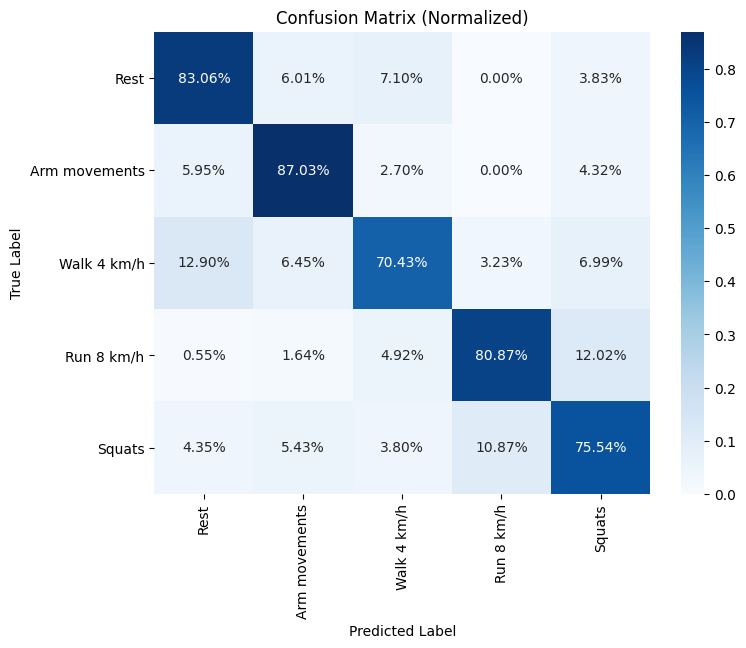

In [298]:
accuracy = accuracy_score(y_test_act, ensemble_pred)
print(accuracy)

class_labels = ['Rest', 'Arm movements', 'Walk 4 km/h', 'Run 8 km/h', 'Squats']

fig = plot_confusion_matrix(y_test_act, pd.Series(np.ravel(ensemble_pred)), class_labels)

## Artefact classification task

### Train test split
- Split the dataset into training and testing set
- One-hot encode data labels, to match the output shape of the model

In [325]:
(X_train_art, 
X_test_art, 
X_val_art, 
X_train_art_fft, 
X_test_art_fft, 
X_val_art_fft, 
y_train_art, 
y_test_art, 
y_val_art) = train_test_validation_split(df_norm, df_fft, 'artefact')

# Get electrode input in the required shape
X_train_art, X_test_art, X_val_art, X_train_art_el, X_test_art_el, X_val_art_el = get_electrode_input(X_train_art, 
                                                                                                      X_test_art, 
                                                                                                      X_val_art)

# One-hot encoding of the output variable
y_train_art_enc = tf.keras.utils.to_categorical(y_train_art - 1, num_classes = ARTEFACT_NUM)
y_val_art_enc = tf.keras.utils.to_categorical(y_val_art - 1, num_classes = ARTEFACT_NUM)

In [326]:
# Check if the indices are equal
check_index(X_train_art, X_test_art, X_val_art, 
            X_train_art_fft, X_test_art_fft, X_val_art_fft, 
            y_train_art, y_test_art, y_val_art)

Train dataset indices match:       True
Test dataset indices match:        True
Validation dataset indices match:  True


In [327]:
# Check if the train data is stratified
y_train_art.value_counts()

1    1469
2    1186
3     323
4     242
Name: artefact, dtype: int64

### Balance dataset

In [376]:
'''
    Function to balance dataframe, will be used after train test split
'''
def balance_dataset(X_train, y_train):
    # Fix random seed so that the same indices are resampled for each dataset
    np.random.seed(40)
    
    train_data = pd.concat([X_train, y_train], axis=1)

    # Separate samples for each value of the artefact column
    artefact_1 = train_data[train_data['artefact'] == 1]
    artefact_2 = train_data[train_data['artefact'] == 2]
    artefact_3 = train_data[train_data['artefact'] == 3]
    artefact_4 = train_data[train_data['artefact'] == 4]

    # Get the size of the majority class
    majority_size = len(artefact_2)

    # Upsample minority classes to match the majority class size
    artefact_2_upsampled = resample(artefact_2, replace = True, n_samples = majority_size)
    artefact_3_upsampled = resample(artefact_3, replace = True, n_samples = majority_size)
    artefact_4_upsampled = resample(artefact_4, replace = True, n_samples = majority_size)
    
    balanced_train_data = pd.concat([artefact_1, artefact_2, artefact_3_upsampled, artefact_4_upsampled])

    # Shuffle the training data
    balanced_train_data = balanced_train_data.sample(frac=1)
    
    # Separate the features and target variable for training
    X_train_balanced = balanced_train_data.drop('artefact', axis=1)
    y_train_balanced = balanced_train_data['artefact']
    
    return X_train_balanced, y_train_balanced

In [377]:
X_train_art_bal, y_train_art_bal = balance_dataset(X_train_art, y_train_art)
X_train_art_fft_bal, _ = balance_dataset(X_train_art_fft, y_train_art)

# One-hot encoding of the output variable
y_train_art_enc_bal = tf.keras.utils.to_categorical(y_train_art_bal - 1, num_classes=ARTEFACT_NUM)

y_train_art_bal.value_counts()

1    1469
4    1186
2    1186
3    1186
Name: artefact, dtype: int64

In [378]:
# Check if the indices are equal
check_index(X_train_art_bal, X_test_art, X_val_art, 
            X_train_art_fft_bal, X_test_art_fft, X_val_art_fft, 
            y_train_art_bal, y_test_art, y_val_art)

Train dataset indices match:       True
Test dataset indices match:        True
Validation dataset indices match:  True


### Model architectures

In [331]:
params = {
    'epochs': 20,
    'batch_size': 16,
    'learning_rate': 0.001, 
    'dropout': 0.3,
    'optimizer': 'Adam',
    'hidden_activation': 'relu',
    'output_activation': 'softmax',
    'loss': 'categorical_crossentropy',
    'metric': 'accuracy',
    'weight_decay': 0
}

In [379]:
'''
    Activity type classification convolutional model, ECG input together with FFT
'''
def artefact_classifier_conv(ecg_len, fft_len, electrode_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name='signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name='frequency_input')
    
    electrode_input = Input(shape=(electrode_len,), name='electrode_input')
    
    # Fully connected and dropout layers for ECG signal
    ecg_dense1 = Dense(1024, activation=params['hidden_activation'])(ecg_input)
    ecg_dense2 = Dense(512, activation=params['hidden_activation'])(ecg_dense1)
    
    fft_reshaped = Reshape((fft_len, 1))(fft_input)
    
    # Convolutional layers for FFT   
    conv1 = Conv1D(64, kernel_size=5, activation='relu')(fft_reshaped)  # Increase number of filters
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, kernel_size=5, activation='relu')(pool1)  # Increase number of filters and kernel size
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    flatten_fft = Flatten()(pool2)
    
    # Concatenate outputs from dense and convolutional layers
    concatenated = concatenate([ecg_dense2, flatten_fft])
    
    # Fully connected layers
#     dense3 = Dense(256, activation=params['hidden_activation'])(concatenated)
    dense4 = Dense(128, activation=params['hidden_activation'])(concatenated)
    
    dense5 = Dense(64, activation=params['hidden_activation'])(dense4)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation=params['output_activation'], name='output')(dense5)
    
    # Optimizer with weight decay
    opt = Adam(weight_decay=params['weight_decay'])
    
    model = Model(inputs=[ecg_input, fft_input], outputs=output)
    
    model.compile(optimizer=opt, loss=params['loss'], metrics=[params['metric']])
    
    return model

model = artefact_classifier_conv(SEG_LEN, FFT_LEN, 1, ARTEFACT_NUM)
model.summary()

Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 reshape_66 (Reshape)        (None, 200, 1)               0         ['frequency_input[0][0]']     
                                                                                                  
 conv1d_135 (Conv1D)         (None, 196, 64)              384       ['reshape_66[0][0]']          
                                                                                                  
 max_pooling1d_135 (MaxPool  (None, 98, 64)               0         ['conv1d_135[0][0]']   

### Training

In [380]:
# Init Neptune.ai project
run = neptune.init_run(
    project="veronika.kalouskova/DP-Artefact-Classification",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTY5NGI5ZS0xNzk1LTQwYjItYjc0Ny1lZWNmZjdjZjg1MzEifQ==",
)

# Log model parameters into Neptune
run['parameters'] = params

# Log model summary and architecture into Neptune
neptune_callback = NeptuneCallback(run=run)

history = model.fit([X_train_art_bal, X_train_art_fft_bal],
                    y_train_art_enc_bal, 
                    epochs = params['epochs'], 
                    batch_size = params['batch_size'], 
                    validation_data=([X_val_art, X_val_art_fft], y_val_art_enc),
                    callbacks=[neptune_callback, lr_scheduler]
                   )

# Log model architecture and weights into Neptune
model.save('models/model.keras')

run['saved_model'].upload('models/model.keras')

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/veronika.kalouskova/DP-Artefact-Classification/e/DPAR-5
Epoch 1/20
315/315 [==============================] - 8s 22ms/step - loss: 0.8762 - accuracy: 0.6175 - val_loss: 0.7475 - val_accuracy: 0.6811 - lr: 0.0010
Epoch 2/20
315/315 [==============================] - 7s 22ms/step - loss: 0.5800 - accuracy: 0.7500 - val_loss: 0.6792 - val_accuracy: 0.7007 - lr: 0.0010
Epoch 3/20
315/315 [==============================] - 7s 21ms/step - loss: 0.4618 - accuracy: 0.8078 - val_loss: 0.6657 - val_accuracy: 0.7332 - lr: 0.0010
Epoch 4/20
315/315 [==============================] - 6s 19ms/step - loss: 0.3448 - accuracy: 0.8615 - val_loss: 0.6741 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 5/20
315/315 [==============================] - 6s 19ms/step - loss: 0.3122 - accuracy: 0.8707 - val_loss: 0.7091 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 6/20
315/315 [==============================] - 6s 19ms/step - loss: 0.2549 -

### Evaluation

In [373]:
'''
    Merges predictions for categories 2 and 3
'''
def evaluate_three_categories(y_test, y_pred):
    y_test_merged = np.where((y_test == 2) | (y_test == 3), 2, y_test)
    y_pred_merged = np.where((y_pred == 2) | (y_pred == 3), 2, y_pred)

    # Reevaluate confusion matrix on the modified data
    class_labels = ['1', '2 a 3', '4']

    fig = plot_confusion_matrix(y_test_merged, y_pred_merged, class_labels)

    accuracy = accuracy_score(y_test_merged, y_pred_merged)
    
    return fig, accuracy

In [374]:
'''
    Merges predictions for categories 1, 2 and 3, measures HR detection
'''
def evaluate_heart_rate_categories(y_test, y_pred):
    y_test_merged = np.where((y_test == 1) | (y_test == 2) | (y_test == 3), 2, y_test)
    y_pred_merged = np.where((y_pred == 1) | (y_pred == 2) | (y_pred == 3), 2, y_pred)

    # Reevaluate confusion matrix on the modified data
    class_labels = ['HR detectable', 'HR not detectable']

    fig = plot_confusion_matrix(y_test_merged, y_pred_merged, class_labels)

    accuracy = accuracy_score(y_test_merged, y_pred_merged)
    
    return fig, accuracy

29/29 [==============================] - 0s 5ms/step


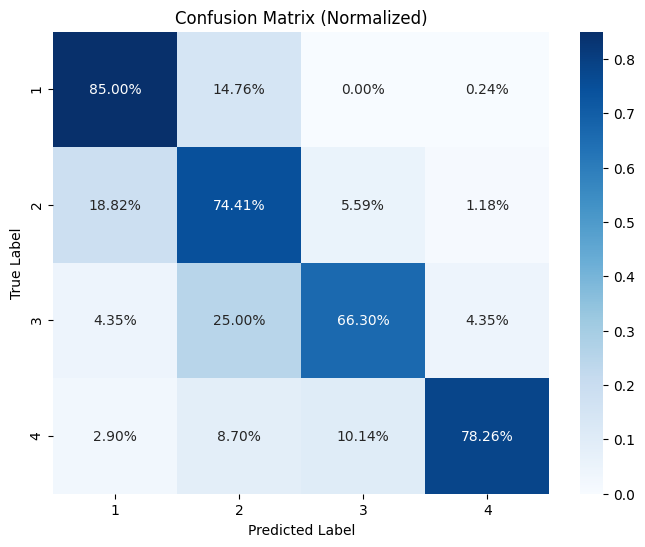

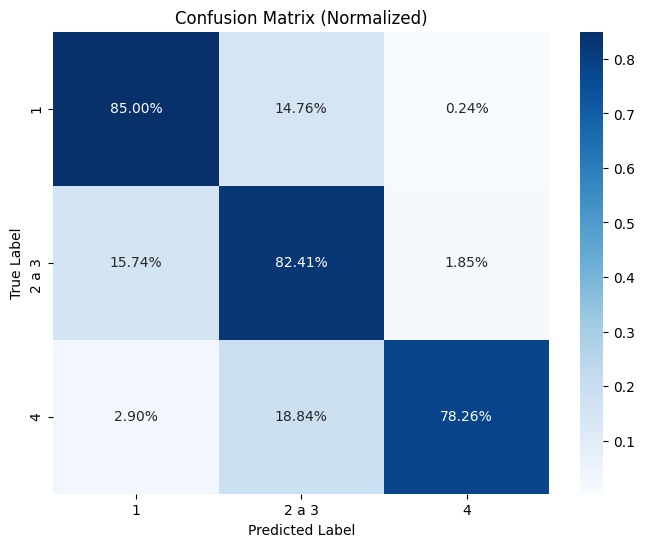

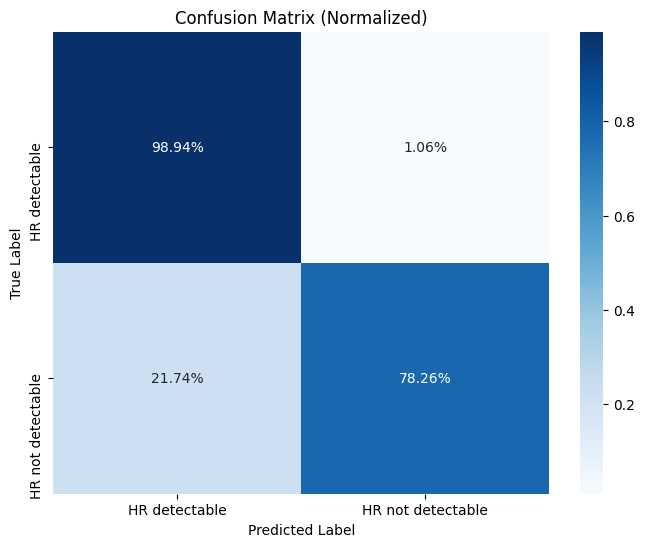

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 6 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/veronika.kalouskova/DP-Artefact-Classification/e/DPAR-5/metadata


In [381]:
class_labels = ['1', '2', '3', '4']

preds_art = model.predict([X_test_art, X_test_art_fft])
y_pred_art = np.argmax(preds_art, axis=1) + 1

accuracy = accuracy_score(y_test_art, y_pred_art)
run["eval/accuracy"] = accuracy

fig = plot_confusion_matrix(y_test_art, y_pred_art, class_labels)
run["eval/confusion_matrix"] = fig

fig, accuracy = evaluate_three_categories(y_test_art, y_pred_art)
run["eval/accuracy_merged"] = accuracy
run["eval/confusion_matrix_merged"] = fig

fig, accuracy = evaluate_heart_rate_categories(y_test_art, y_pred_art)
run["eval/accuracy_HR"] = accuracy
run["eval/confusion_matrix_HR"] = fig

run.stop()